# Circuit simulation using NgSpice in Python Jupyter

By Shuo Chen (chenshuo_at_chenshuo.com)

Latest notebook: https://github.com/chenshuo/notes/blob/master/notebooks/AnalogCircuits.ipynb

Blog post about why I like this over GUI tool (LTspice):
http://blog.chenshuo.com/2024/02/ngspice-python-jupyter.html

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# NgSpice
import ngspyce as ng

In [3]:
# Circuitikz
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

In [4]:
def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue

        print('%10s = %8.2f uA' % (k, 1e6*op[k][0]))
    else:
        print('%10s = %8.2f mV' % (k, 1e3*op[k][0]))

In [5]:
ng.circ('''
  V1 vcc 0 15
  R1 vcc b 47k
  R2 b 0 4k
''')
ng.operating_point()

{'v1#branch': array([-0.00029412]),
 'b': array([1.17647059]),
 'vcc': array([15.])}

In [6]:
print(ng.vector_names())

['v1#branch', 'b', 'vcc']


In [7]:
print(ng.vectors())

{'v1#branch': array([-0.00029412]), 'b': array([1.17647059]), 'vcc': array([15.])}


In [8]:
Vb = ng.vector('b')
print(Vb)

[1.17647059]


In [9]:
Vcc = 15
Vbb = 4 / (4 + 47) * Vcc
print(Vbb)

1.1764705882352942


In [10]:
print(Vbb - Vb[0])

-2.220446049250313e-16


# Setting Q-point of basic CE amplifier 

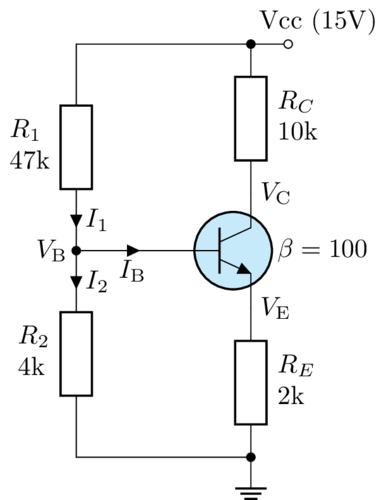

In [24]:
%%tikz -p circuitikz -s 400,500
\ctikzset{european resistors, transistors/arrow pos=end, transistors/fill=cyan!20}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}
\draw (0, 0) node [npn, tr circle] (Q) {$\beta=100$};
\draw (Q.C) to [R, l2_={$R_C$ and 10k}] ++(0, 2) coordinate (Vcc)
  to [short, -o] ++(0.5, 0) ++(0.4, 0) node [above] {Vcc (15V)}; 
\draw (Q.B) to [short, -*, i<={$\ui{B}$}] ++ (-1.5, 0) coordinate (B);
\draw (Q.E) node [right] {$\uv{E}$}
to [R, l2={$R_E$ and 2k}, -*] ++(0, -2) coordinate (G) node[ground]{};
\draw (B) to [R, l2={$R_1$ and 47k}, i<_={$I_1$}] (B|-Vcc) to [short, -*] (Vcc);
\draw (B) to [R, l2_={$R_2$ and 4k}, i>^={$I_2$}] (B|-G) to [short] (G);
%\draw (B) to [C, -o] ++(-1.5, 0) node [left] {Vin};
\draw (Q.C) node [right] {$\uv{C}$} ; %to [short, *-o] ++(0.7, 0) node[above] (O) {Vout};
\draw (B) node [left] {$\uv{B}$};

Thevenin's theorem

In [11]:
Rb = para(4, 47)
print(Rb)

3.6862745098039214


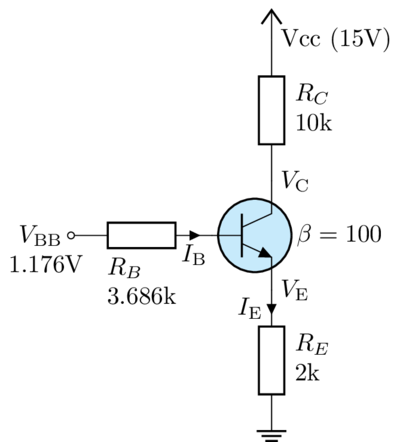

In [42]:
%%tikz -p circuitikz -s 400,500
\ctikzset{european resistors, transistors/arrow pos=end, transistors/fill=cyan!20}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}
\draw (0, 0) node [npn, tr circle] (Q) {$\beta=100$};
\draw (Q.C) to [R, l2_={$R_C$ and 10k}, bipoles/length=1.2cm] ++(0, 2) coordinate (Vcc)
  node [vcc] {} node [right] {Vcc (15V)}; 
\draw (Q.B) to [R, -o, i<={$\ui{B}$}, bipoles/length=1.2cm,l2={$R_B$ and 3.686k}] ++ (-2, 0) coordinate (B);
\draw (Q.E) node [right] {$\uv{E}$}
to [R, l2={$R_E$ and 2k}, i>_={\ui{E}}, bipoles/length=1.2cm] ++(0, -2) coordinate (G) node[tlground]{};
\draw (Q.C) node [right] {$\uv{C}$} ;
\draw (B) node [left] {$\uv{BB}$};
\draw (B)++(0.3, -0.4) node [left] {1.176V};

$I_B \cdot R_B + V_{BE} + I_E \cdot R_E = V_{BB}$

$I_E = (1+\beta)I_B$

$I_B \cdot R_B + (1+\beta)I_B \cdot R_E = V_{BB} - V_{BE}$

In [12]:
Vbe = 0.7
beta = 100
Re = 2

Ib = (Vbb - Vbe) / (Rb  + (1+beta) * Re)
print('Ib = %.3f μA' % (Ib * 1e3))

Ib = 2.316 μA


In [13]:
Vcc = 15
Rc = 10

Vc = Vcc - Rc * beta * Ib
print('Vc = %.2f V' % Vc)

Vc = 12.68 V


$I_B = I_E/(1+\beta)$

$I_E/(1+\beta)\cdot R_B + I_E \cdot R_E = V_{BB} - V_{BE}$

In [14]:
Ie = (Vbb - Vbe) / (Rb/(1+beta) + Re)
print('Ie = %.4f mA' % (Ie))
Ic = beta / (1+beta) * Ie
print('Ic = %.4f mA' % (Ic))

Ie = 0.2340 mA
Ic = 0.2316 mA


In [15]:
Vc = Vcc - Rc * Ic
print('Vc = %.2f V' % Vc)

Vc = 12.68 V


## Operating point

In [11]:
ng.circ('''
  V1 vcc 0 15
  R1 vcc b 47k
  R2 b 0 4k
  Q1 c b e npn
  Rc vcc c 10k
  Re e 0 2k
  .model npn npn(BF=100)
  .options savecurrents
''')
op = print_op()

   @q1[ib] =     2.15 uA
   @q1[ic] =   214.90 uA
    @r1[i] =   294.29 uA
    @r2[i] =   292.14 uA
    @rc[i] =   214.90 uA
    @re[i] =   217.04 uA
         b =  1168.55 mV
         c = 12851.05 mV
         e =   434.09 mV
 v1#branch =  -509.18 uA
       vcc = 15000.00 mV


In [17]:
Vb = ng.vector('b')
Ve = ng.vector('e')
Ib = ng.vector('@q1[ib]')
Ic = ng.vector('@q1[ic]')
print('Vbe = %.3f V' % (Vb - Ve))
print('Ib = %.3f μA' % (Ib * 1e6))
print('beta = %.0f' % (Ic / Ib))

Vbe = 0.734 V
Ib = 2.149 μA
beta = 100


## DC sweep

In [18]:
ng.cmd('dc r1 10k 100k 100')
# print(ng.vector_names())
r1 = ng.vector('res-sweep')
Vb = ng.vector('b')
Ve = ng.vector('e')
Vc = ng.vector('c')
Ib = ng.vector('@q1[ib]')
Ic = ng.vector('@q1[ic]')

(1.0, 16.0)

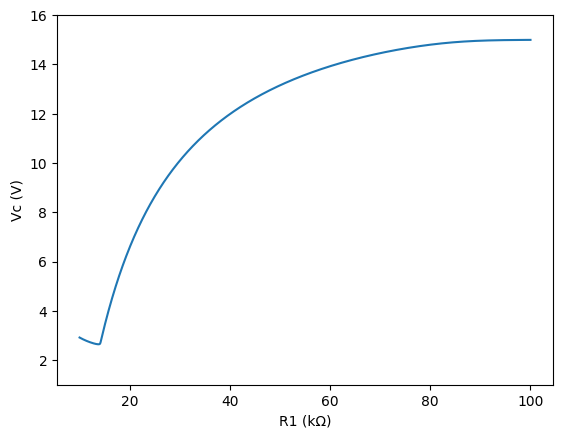

In [19]:
plt.plot(r1/1e3, Vc)
plt.xlabel('R1 (kΩ)')
plt.ylabel('Vc (V)')
plt.ylim(1, 16)

In [12]:
ng.cmd('alter r1 22k')
op = print_op()

   @q1[ib] =     7.50 uA
   @q1[ic] =   750.29 uA
    @r1[i] =   578.08 uA
    @r2[i] =   570.57 uA
    @rc[i] =   750.25 uA
    @re[i] =   757.75 uA
         b =  2282.30 mV
         c =  7497.52 mV
         e =  1515.50 mV
 v1#branch = -1328.32 uA
       vcc = 15000.00 mV


## Temperature sweep

Text(0, 0.5, 'Ic (mA)')

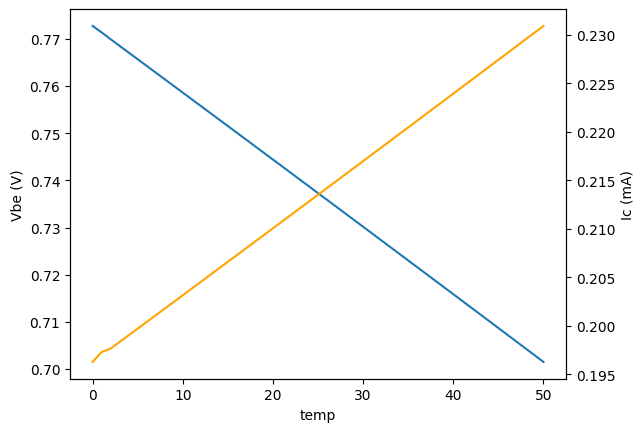

In [49]:
ng.cmd('dc temp 0 50 1')
temp = ng.vector('temp-sweep')
Ic = ng.vector('@q1[ic]')
Vb = ng.vector('b')
Ve = ng.vector('e')
fig, ax = plt.subplots()
plt.plot(temp, Vb-Ve, label='Vbe')
plt.xlabel('temp')
plt.ylabel('Vbe (V)')
ax2 = ax.twinx()
plt.plot(temp, Ic*1e3, 'red', label='Icq')
plt.ylabel('Ic (mA)')

* Robert Widlar, An exact expression for the thermal variation of the emitter base voltage of bi-polar transistors.
Proceedings of the IEEE ( Volume: 55, Issue: 1, January 1967)

* Yannis P. Tsividis, Accurate Analysis of Temperature Effects in $I_\mathrm{C}-V_\mathrm{BE}$
Characteristics with Application to Bandgap Reference Sources.
_IEEE Journal of Solid-State Circuits_, 1980.

In [53]:
# Linear regression

Vbe = Vb - Ve
print(Vbe[0])
m, b = np.polyfit(temp, Vbe, 1)
print(m, b)
t = -273.15
print(m*t + b)

0.7727645132021105
-0.0014251114229438106 0.7728809479739165
1.1619363664375768


# TL431 Regulator

SPICE model by Eugene Dvoskin 2012, downloaded from 
https://www.audio-perfection.com/voltage-regulators/linear-regulators/accurate-tl431-model-development-analysis-and-evaluation/

## Shunt regulator

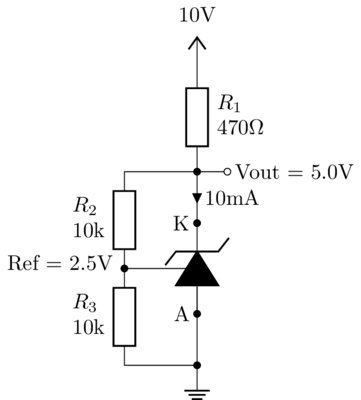

In [25]:
%%tikz -p circuitikz -s 400,400
\ctikzset{european resistors, american currents}
\draw (0, 0) node[left] {A}
  to [zzD*, n=D, *-*] ++(0, 1.5) coordinate (K)
  node [left] {K};

\draw (D.center) to [short] ++(-1.2, 0)
  coordinate (R)
  to [R, l2={$R_2$ and 10k}, bipoles/length=1.2cm] ++(0, 1.6)
  coordinate (R2)
  to [short, -*] (R2 -|D)
  to [short, i={10mA}]  (K);
\draw (R2-|D) to [short, -o] ++(0.5, 0)
  node [right] {Vout = 5.0V};
\draw (R) node [circ] {}
  to [R, l2_={$R_3$ and 10k}, bipoles/length=1.2cm] ++(0, -1.6)
  coordinate (R3)
  to [short, -*] (R3 -|D)
  node [ground] {}
  to (D);

\draw (R2 -|D) to [R, l2_={$R_1$ and 470$\Omega$}, bipoles/length=1.2cm] ++(0, 1.8)
  node [vcc] {10V};
%\draw (R) ++(0.2, 0) node [below] {2.495V};
\draw (R) ++(0, 0.1) node [left=2pt] {Ref = 2.5V};


In [27]:
ng.circ('''
  V1 v1 0 10V
  R1 v1 K 470
  R2 K REF 10k
  R3 REF 0 10k
  X1 K 0 REF TL431ED
  .options savecurrents

**********************************************************************************
* Model developed by Eugene Dvoskin  "http://www.audio-perfection.com"  02/05/2012
* This TL431 model has been developed from schematic in the datasheet
* http://www.ti.com/lit/ds/symlink/tl431.pdf
* It matches most of DC, AC, Transient, Stability and Noise performance of TI TL431
* No attempts were made to cover Temperature dependences
*********************************************************************************
.SUBCKT TL431ED CATHODE ANODE REF
Q1 CATHODE REF q1e QN_ED
R4 q1e N009 3.28k
R2 N009 q2b 2.4k
R3 N009 q5b 7.2k
Q2 q2b q2b ANODE QN_ED area=1.2
Q3 q5b q2b q3e QN_ED area=2.2
R1 q3e ANODE 800
Q4 q7b q1e q4e QN_ED
R5 q4e q5c 4k
Q5 q5c q5b ANODE QN_ED
Q6 q9b q6b ANODE QN_ED area=0.5
Q7 q7b q7b q7e QP_ED
Q8 q9b q7b q8e QP_ED
R7 CATHODE q7e 800
R8 CATHODE q8e 800
Q9 CATHODE q9b q9e QN_ED
R9 q10b q9e 150
Q10 CATHODE q10b ANODE QN_ED area=5
R10 q10b ANODE 10k
Q11 q9b q9b REF QN_ED
D1 ANODE q9b D_ED
R6 q6b q2b 1k
D2 ANODE CATHODE D_ED
C1 CATHODE q9b 10p
C2 q5b q5c 20p
.model QN_ED NPN(BF=140 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
.model QP_ED PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
.MODEL D_ED D(Rs=5 CJ0=4.0p)
.ends TL431ED
''')
print_op(True, True)

ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-03 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-04 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-05 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-06 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   5.6234E-06 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   2.3714E-06 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   6.4938E-07 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   9.3057E-08 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   9.3057E-09 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   9.3057E-10 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   9.3057E-11 Note: One successful gmin step
ERROR:ngspyc

@c.x1.c1[i] =     0.00 uA
@c.x1.c2[i] =     0.00 uA
@d.x1.d1[id] =    -0.00 uA
@d.x1.d2[id] =    -0.00 uA
@q.x1.q10[ib] =    67.87 uA
@q.x1.q10[ic] =  9854.02 uA
@q.x1.q10[ie] = -9921.89 uA
@q.x1.q11[ib] =    -0.00 uA
@q.x1.q11[ic] =    -0.00 uA
@q.x1.q11[ie] =    -0.00 uA
@q.x1.q1[ib] =     1.45 uA
@q.x1.q1[ic] =   206.62 uA
@q.x1.q1[ie] =  -208.07 uA
@q.x1.q2[ib] =     1.10 uA
@q.x1.q2[ic] =   151.99 uA
@q.x1.q2[ie] =  -153.09 uA
@q.x1.q3[ib] =     0.39 uA
@q.x1.q3[ic] =    53.21 uA
@q.x1.q3[ie] =   -53.59 uA
@q.x1.q4[ib] =     0.46 uA
@q.x1.q4[ic] =    65.15 uA
@q.x1.q4[ie] =   -65.61 uA
@q.x1.q5[ib] =     0.47 uA
@q.x1.q5[ic] =    65.61 uA
@q.x1.q5[ie] =   -66.08 uA
@q.x1.q6[ib] =     0.45 uA
@q.x1.q6[ic] =    62.88 uA
@q.x1.q6[ie] =   -63.33 uA
@q.x1.q7[ib] =    -1.07 uA
@q.x1.q7[ic] =   -63.04 uA
@q.x1.q7[ie] =    64.11 uA
@q.x1.q8[ib] =    -1.04 uA
@q.x1.q8[ic] =   -63.89 uA
@q.x1.q8[ie] =    64.94 uA
@q.x1.q9[ib] =     1.01 uA
@q.x1.q9[ic] =   145.99 uA
@q.x1.q9[ie] =  -147.01 

(In-)stability.

https://electronics.stackexchange.com/questions/332064/strange-oscillations-with-tl431-voltage-reference

ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-03 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-04 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-05 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-06 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-07 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-08 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-09 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-10 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-11 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-12 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-12 Note: One successful gmin step
ERROR:ngspyce

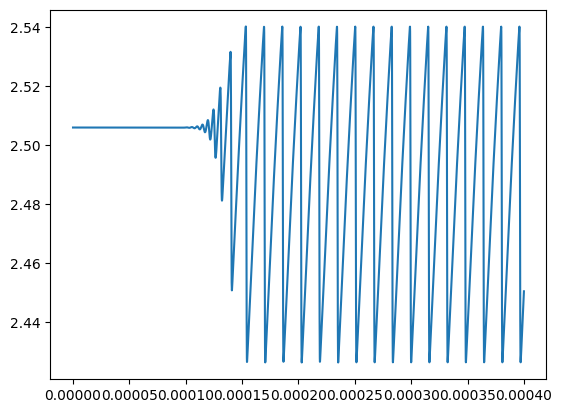

In [35]:
ng.circ('''
  V1 v1 0 3.3V
  R1 v1 K 750
  C1 K 0 0.1u; to make it oscillating
  X1 K 0 K TL431ED
  .options savecurrents

.SUBCKT TL431ED CATHODE ANODE REF
Q1 CATHODE REF q1e QN_ED
R4 q1e N009 3.28k
R2 N009 q2c 2.4k
R3 N009 q3c 7.2k
Q2 q2c q2c ANODE QN_ED area=1.2
Q3 q3c q2c q3e QN_ED area=2.2
R1 q3e ANODE 800
Q4 q7b q1e q4e QN_ED
R5 q4e q5c 4k
Q5 q5c q3c ANODE QN_ED
Q6 q9b q6b ANODE QN_ED area=0.5
Q7 q7b q7b q7e QP_ED
Q8 q9b q7b q8e QP_ED
R7 CATHODE q7e 800
R8 CATHODE q8e 800
Q9 CATHODE q9b q9e QN_ED
R9 q10b q9e 150
Q10 CATHODE q10b ANODE QN_ED area=5
R10 q10b ANODE 10k
Q11 q9b q9b REF QN_ED
D1 ANODE q9b D_ED
R6 q6b q2c 1k
D2 ANODE CATHODE D_ED
C1 CATHODE q9b 10p
C2 q3c q5c 20p
.model QN_ED NPN(BF=140 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
.model QP_ED PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
.MODEL D_ED D(Rs=5 CJ0=4.0p)
.ends TL431ED
''')

ng.cmd('tran 100n 400u')

t = ng.vector('time')
Vout = ng.vector('k')
plt.plot(t, Vout)

## Linear series voltage regulator

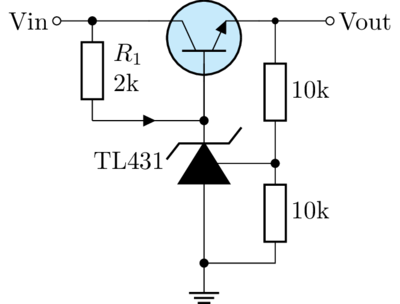

In [16]:
%%tikz -p circuitikz -s 400,400
\ctikzset{european resistors, diodes/fill=cyan!20, transistors/arrow pos=end, transistors/fill=cyan!20, amplifiers/fill=cyan!20}
%\ctikzset{bipoles/length=1cm};
\draw (0, 0)
    node [left] {Vin}
    to [short, o-*] ++(0.5, 0) coordinate(A)
    to [R, l2={$R_1$ and 2k}, bipoles/length=1cm] ++(0, -1.4) coordinate(B);
\draw (A) to [short] ++(0.8, 0) node [npn, tr circle, anchor=C, rotate=90](Q1){};
\draw (B) to [short, -*, i=~] (B-|Q1.B) coordinate(M) to [short] (Q1.B);
\draw (M) to [short] ++(0, 0.80)
  to [zzD*, n=D, invert, mirror, l_=TL431] ++(0, -2.8)
  coordinate (G) node [ground] {};
\draw (Q1.E) to [short, -o] ++(1,0) node [right] {Vout};
\draw (D.center) to [short, -*] ++(1, 0) coordinate (M)
  to [R,l=10k, bipoles/length=1cm] (M|-G) to [short, -*] (G);
\draw (M) to [R, l_=10k, -*, bipoles/length=1cm] (M|-A);

In [27]:
ng.circ('''
  Vin ac1 ac2 DC 10 SINE(0 10 50)
  D1 ac1 vin D
  D2 ac2 vin D
  D3 0 ac1 D
  D4 0 ac2 D

  C1 vin 0 330u

  R1 vin b 2k
  Q1 vin b out 2N2222
  Rload out 0 100
  R3 out ref 10k
  R4 ref 0 10k

  X1 b 0 ref TL431ED

  .model 2N2222 npn (IS=2.20f NF=1.00 BF=240 VAF=114
+ IKF=0.293 ISE=2.73p NE=2.00 BR=4.00 NR=1.00
+ VAR=24.0 IKR=0.600 RE=0.194 RB=0.777 RC=77.7m
+ XTB=1.5 CJE=24.9p VJE=1.10 MJE=0.500 CJC=12.4p VJC=0.300
+ MJC=0.300 TF=371p TR=64.0n EG=1.12 )

  .model D D

  * .options savecurrents

**********************************************************************************
* Model developed by Eugene Dvoskin  "http://www.audio-perfection.com"  02/05/2012
* This TL431 model has been developed from schematic in the datasheet
* http://www.ti.com/lit/ds/symlink/tl431.pdf
* It matches most of DC, AC, Transient, Stability and Noise performance of TI TL431
* No attempts were made to cover Temperature dependences
*********************************************************************************
.SUBCKT TL431ED CATHODE ANODE REF
Q1 CATHODE REF q1e QN_ED
R4 q1e N009 3.28k
R2 N009 q2b 2.4k
R3 N009 q5b 7.2k
Q2 q2b q2b ANODE QN_ED area=1.2
Q3 q5b q2b q3e QN_ED area=2.2
R1 q3e ANODE 800
Q4 q7b q1e q4e QN_ED
R5 q4e q5c 4k
Q5 q5c q5b ANODE QN_ED
Q6 q9b q6b ANODE QN_ED area=0.5
Q7 q7b q7b q7e QP_ED
Q8 q9b q7b q8e QP_ED
R7 CATHODE q7e 800
R8 CATHODE q8e 800
Q9 CATHODE q9b q9e QN_ED
R9 q10b q9e 150
Q10 CATHODE q10b ANODE QN_ED area=5
R10 q10b ANODE 10k
Q11 q9b q9b REF QN_ED
D1 ANODE q9b D_ED
R6 q6b q2b 1k
D2 ANODE CATHODE D_ED
C1 CATHODE q9b 10p
C2 q5b q5c 20p
.model QN_ED NPN(BF=140 Cje=1p Cjc=2p Rb=40 VAF=80 VAR=50 KF=3.2e-16 AF=1)
.model QP_ED PNP(BF=60 Cje=1p Cjc=3p Rb=80 VAF=70 VAR=40)
.MODEL D_ED D(Rs=5 CJ0=4.0p)
.ends TL431ED
''')
print_op()

ERROR:ngspyce.sharedspice:Note: vin: dc value used for op instead of transient time=0 value.
ERROR:ngspyce.sharedspice:Note: Starting dynamic gmin stepping
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-03 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-04 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-05 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-06 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.0000E-07 Warning: Further gmin increment
ERROR:ngspyce.sharedspice:Trying gmin =   5.6234E-07 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   2.3714E-07 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   6.4938E-08 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   3.3982E-08 Note: One successful gmin step
ERROR:ngspyce.sharedspice:Trying gmin =   1.2864E-08 Note: One successful gmin step
ERR

       ac1 =  9242.93 mV
       ac2 =  -757.07 mV
         b =  5829.47 mV
       out =  5019.53 mV
       ref =  2502.59 mV
       vin =  8485.85 mV
vin#branch = -51513.23 uA
   x1.n009 =  1089.91 mV
   x1.q10b =   720.51 mV
    x1.q1e =  1769.82 mV
    x1.q2b =   721.15 mV
    x1.q3e =    42.84 mV
    x1.q4e =  1067.30 mV
    x1.q5b =   703.73 mV
    x1.q5c =   808.87 mV
    x1.q6b =   720.70 mV
    x1.q7b =  5076.07 mV
    x1.q7e =  5778.96 mV
    x1.q8e =  5778.09 mV
    x1.q9b =  1438.55 mV
    x1.q9e =   731.98 mV


## Transient analysis

ERROR:ngspyce.sharedspice:Note: vin: dc value used for op instead of transient time=0 value.


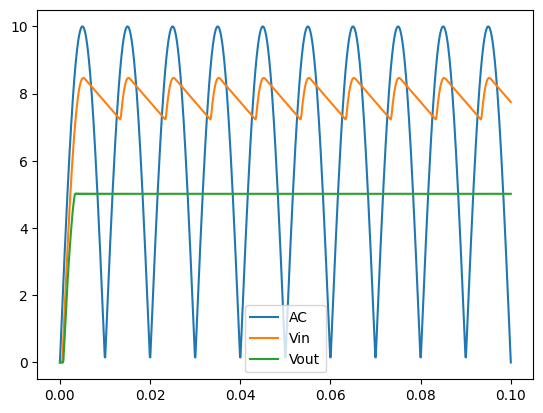

In [46]:
ng.cmd('tran 100u 100m')
t = ng.vector('time')
ac = np.abs(ng.vector('ac1') - ng.vector('ac2'))
vin = ng.vector('vin')
vout = ng.vector('out')
plt.plot(t, ac, label='AC')
plt.plot(t, vin, label='Vin')
plt.plot(t, vout, label='Vout')
plt.legend()